In [193]:
%matplotlib inline


## Load data


In [194]:
import numpy as np 
import pandas as pd 
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import numpy as np
from glob import glob
from skimage.io import imread
from livelossplot import PlotLossesKerasTF
from functools import *
import elasticdeform

import random
os.environ["CUDA_VISIBLE_DEVICES"]='1'

BASE_IMG_PATH=os.path.join('hecktor-master','data','resampled')
BATCH_SIZE = 3
INPUT_SHAPE = (144,144,144,2)
PROJECT_NAME = 'hector'
AUG_RATE = 0.3


random.seed(42)
random_seed = 42

AUGMENTATION_OPS = [
    lambda t: np.rot90(t, axes=(1, 2), k=1),  # 90 degree rotation
    lambda t: np.rot90(t, axes=(1, 2), k=2),  # 180 degree rotation
    lambda t: np.rot90(t, axes=(1, 2), k=3),  # 270 degree rotation
    lambda t: np.flip(t, axis=0),  # Axial flip
    lambda t: np.flip(t, axis=1),  # Sagittal flip
    lambda t: np.flip(t, axis=2)  # Coronal flip
]


In [195]:
glob(os.path.join(BASE_IMG_PATH,'*'))


['hecktor-master/data/resampled/CHGJ073_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ035_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHGJ082_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS069_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHGJ083_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS052_ct.nii.gz',
 'hecktor-master/data/resampled/CHUM047_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ025_ct.nii.gz',
 'hecktor-master/data/resampled/CHUS041_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS097_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS046_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS055_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHMR013_ct.nii.gz',
 'hecktor-master/data/resampled/CHUS015_ct.nii.gz',
 'hecktor-master/data/resampled/CHUM027_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS015_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ053_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS098_ct.nii.gz',
 'hecktor-master/data/resampled/CH

In [196]:
# show some of the files
all_ct_images= glob(os.path.join(BASE_IMG_PATH,'*ct.nii.gz'))
all_pt_images = [x.replace('ct.nii.gz', 'pt.nii.gz') for x in all_ct_images]
all_mask_images = [x.replace('ct.nii.gz', 'ct_gtvt.nii.gz') for x in all_ct_images]
np.random.seed(42)
rand_index = np.random.randint(0, len(all_ct_images))
print(len(all_ct_images),' matching files found:',all_ct_images[rand_index], all_pt_images[rand_index])
print(len(all_mask_images),' matching files found:',all_ct_images[rand_index], all_mask_images[rand_index])


201  matching files found: hecktor-master/data/resampled/CHUS074_ct.nii.gz hecktor-master/data/resampled/CHUS074_pt.nii.gz
201  matching files found: hecktor-master/data/resampled/CHUS074_ct.nii.gz hecktor-master/data/resampled/CHUS074_ct_gtvt.nii.gz


(144, 144, 144)


Text(0.5, 1.0, 'Mask')

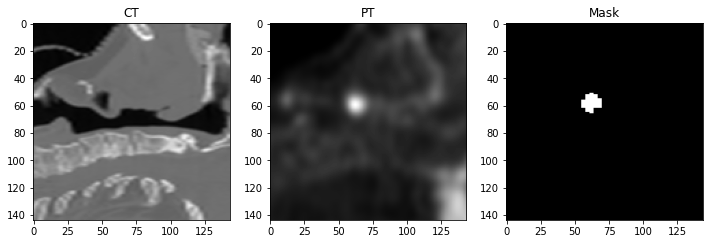

In [197]:
%matplotlib inline
try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')
    
test_ct=np.asarray(nib.load(all_ct_images[rand_index]).dataobj)
test_pt=np.asarray(nib.load(all_pt_images[rand_index]).dataobj)
test_mask=np.asarray(nib.load(all_mask_images[rand_index]).dataobj)
print(test_ct.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))

ax1.imshow(test_ct[test_ct.shape[0]//2], cmap = 'gray')
ax1.set_title('CT')
ax2.imshow(test_pt[test_pt.shape[0]//2], cmap = 'gray')
ax2.set_title('PT')
ax3.imshow(test_mask[test_mask.shape[0]//2], cmap = 'gray')
ax3.set_title('Mask')

In [198]:
def make144(image):
    new_image = image[:144,:144,:144]
    return new_image

def preprocess(image):
    if image.shape != (144,144,144):
        image = make144(image)
    new_image = (image - image.mean())/image.std()
    
    return new_image
print(test_pt.max(), test_pt.min(),test_pt.shape)
new_img = preprocess(test_pt)
print(new_img.max(), new_img.min(),new_img.shape)

12.489239 -0.0050189 (144, 144, 144)
9.617565 -0.9385557 (144, 144, 144)


In [199]:
data = preprocess(test_pt)
data = np.concatenate((data, preprocess(test_pt)), -1)
data.shape

(144, 144, 288)

In [200]:
#check if ct, pt, mask have same numbers.

from sklearn.model_selection import train_test_split

if not len(all_ct_images) == len(all_pt_images) == len(all_mask_images):
    print(len(all_ct_images), len(all_pt_images), len(all_mask_images))
    raise ValueError('ct,pt,mask number not match')

data_list_index = range(len(all_ct_images))
train_data_list, val_data_list = train_test_split(data_list_index, test_size = 0.2, random_state = 42)


In [201]:
from functools import *

def get_augment_operations(random_state, probability=.25):
    """
    Return a function that can be applied for augmenting a tensor.
    Included operations are:
        - flipping (axial, sagittal and coronal);
        - rotation (90, 180 and 720).
    Each of the six operations has a certain probability to be included for 
    augmentation.
    :param random_state: random state.
    :param probability: probability for operation inclusion.
    :return: function to apply to tensor.
    """
    probabilities = random_state.uniform(size=len(AUGMENTATION_OPS))
    operations = [
        f for p, f in zip(probabilities, AUGMENTATION_OPS) if p > probability
    ]

    def _wrapped(x):
        augmented = reduce(lambda t, f: f(t), operations, x)
        assert augmented.shape == x.shape
        return augmented

    return _wrapped

# Augment
#f = get_augment_operations(random_state, augment_probability)
#x = f(x)
#y = f(y)

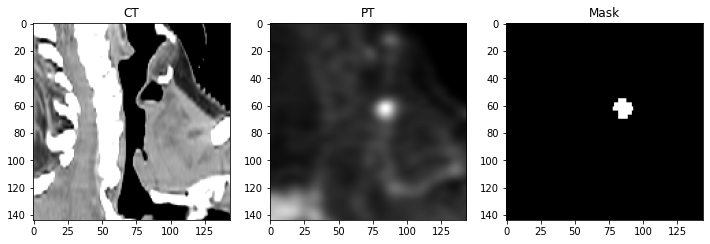

In [202]:
# Augment test

random_state = np.random.RandomState()
f = get_augment_operations(random_state)

_aug_test_ct = f(test_ct)
_aug_test_pt = f(test_pt)
_aug_test_mask = f(test_mask)
_aug_test_ct[_aug_test_ct<-150]=-150
_aug_test_ct[_aug_test_ct>150]=150

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))

ax1.imshow(_aug_test_ct[_aug_test_ct.shape[0]//2], cmap = 'gray')
ax1.set_title('CT')
ax2.imshow(_aug_test_pt[_aug_test_pt.shape[0]//2], cmap = 'gray')
ax2.set_title('PT')
ax3.imshow(_aug_test_mask[_aug_test_mask.shape[0]//2], cmap = 'gray')
ax3.set_title('Mask')
plt.show()



In [215]:
import tensorflow as tf
import random
from scipy.ndimage import zoom
def tf_data_generator(file_list, batch_size = 2, augment_rate = 0):

    i = 0
    j = 0
    if augment_rate!=0:
        #if we want to augmenation
        k = int(len(file_list) * augment_rate)
        indicies = random.sample(range(len(file_list)), k)
        aug_list = [file_list[i] for i in indicies]
            
    while True:
        if i*batch_size >= (len(file_list) * (1 + augment_rate)): 
            #start again
            i = 0
            j = 0
            np.random.shuffle(file_list)
            
        if augment_rate != 0 and i*batch_size >= len(file_list):  
            #augmentation
            # if data in augmentation list 
            file_chunk = aug_list[j*batch_size:(j+1)*batch_size] 
            data = []
            labels = []
            for file in file_chunk:   
                _ct=np.asarray(nib.load(all_ct_images[file]).dataobj)
                _pt=np.asarray(nib.load(all_pt_images[file]).dataobj)
                _mask=np.asarray(nib.load(all_mask_images[file]).dataobj)
                _ct[_ct<-150] = -150
                _ct[_ct>150] = 150

                _ct = preprocess(_ct)
                _pt = preprocess(_pt)
                _mask = make144(_mask)
                #print(_ct.shape, _pt.shape, _mask.shape)              
                if i % 2 == 0 :
                    #elastic deformation
                    num1, num2 = sorted(random.sample(set([0, 1, 2]), 2))
                    [_ct, _pt, _mask] = elasticdeform.deform_random_grid([_ct, _pt, _mask] , sigma=3, points=4, 
                                                                      axis=[(num1, num2), (num1, num2), (num1, num2)])            
                #if i % 3 == 0:
                #    r = random.randrange(10, 13, 1)
                #    r = r/10
                #    _ct = make144(zoom(_ct, (r, r, r), mode = 'nearest'))
                #    _pt = make144(zoom(_pt, (r, r, r), mode = 'nearest'))
                #    _mask = make144(zoom(_mask, (r, r, r), mode = 'nearest'))
                #    
                #_mask[_mask<0.5] = 0 
                #_mask[_mask >= 0.5] = 1
                #
                #img = np.concatenate((_ct[..., np.newaxis], _pt[..., np.newaxis]), -1)
                #
                #if i % 1 == 0 :
                #    #print("rotation, flip deformation")
                #    #rotation, flip augmentation
                #    random_state = np.random.RandomState()
                #    f = get_augment_operations(random_state)
                #    img = f(img)
                #    _mask = f(_mask)
            
                data.append(img) 
                #binarization again for deformated masks.

                labels.append(_mask)
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1
            j = j + 1

        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            for file in file_chunk:
                _ct=np.asarray(nib.load(all_ct_images[file]).dataobj)
                _pt=np.asarray(nib.load(all_pt_images[file]).dataobj)
                _mask=np.asarray(nib.load(all_mask_images[file]).dataobj)

                _ct[_ct<-150] = -150
                _ct[_ct>150] =150
                
                _ct = preprocess(_ct)
                _pt = preprocess(_pt)
                
                img = np.concatenate((_ct[..., np.newaxis], _pt[..., np.newaxis]), -1)
                
                data.append(img) 
                _mask = make144(_mask)
                
                labels.append(_mask)
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1
            
batch_size = BATCH_SIZE
augment_rate = AUG_RATE
#tf_data_generator(train_data_list)


train_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [train_data_list, batch_size, augment_rate],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144)))        

valid_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [val_data_list, batch_size],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144))) 

#test the data generator
num = 0
for data, labels in train_dataset:
    print(data.shape, labels.shape)
    print(labels.shape)
    num = num + 1
    if num > 7: break
print("testing valid pipeline")  
for data, labels in valid_dataset:
    print(data.shape, labels.shape)

    num = num + 1
    if num > 0: break

(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
(3, 144, 144, 144, 2) (3, 144, 144, 144)
(3, 144, 144, 144)
testing valid pipeline
(3, 144, 144, 144, 2) (3, 144, 144, 144)


In [204]:
r = random.randrange(8, 12, 1)
r/10

1.0

## Densely 3D Unet

In [12]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2


def denseBlock(t, nb_layers):
    for _ in range(nb_layers):
        tmp = t
        t = BatchNormalization(axis=1,
                                gamma_regularizer=l2(0.0001),
                                beta_regularizer=l2(0.0001))(t)

        t = Activation('relu')(t)
        t = Conv3D(16, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
        t = Dropout(0.2)(t)
        t = concatenate([t, tmp])
    return t

def transitionDown(t, nb_features):
    t = BatchNormalization(axis=1,
                            gamma_regularizer=l2(0.0001),
                            beta_regularizer=l2(0.0001))(t)
    t = Activation('relu')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    t = Dropout(0.2)(t)
    #t = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same', data_format='channels_last')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1),strides=(2,2,1), padding='same', data_format='channels_last')(t)
    
    return t

def Tiramisu3D(layer_per_block, n_pool=4, growth_rate=16):
    input_layer = Input(shape=INPUT_SHAPE)
    t = Conv3D(48, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(input_layer)

    #dense block
    nb_features = 48
    skip_connections = []
    for i in range(n_pool):
        t = denseBlock(t, layer_per_block[i])
        skip_connections.append(t)
        nb_features += growth_rate * layer_per_block[i]
        t = transitionDown(t, nb_features)

    t = denseBlock(t, layer_per_block[n_pool]) # bottle neck

    skip_connections = skip_connections[::-1] #subvert the array

    for i in range(n_pool):
        keep_nb_features = growth_rate * layer_per_block[n_pool + i]
        t = Conv3DTranspose(keep_nb_features, strides=(2,2,1), kernel_size=(3, 3, 3), padding='same', data_format='channels_last')(t) # transition Up
        t = concatenate([t, skip_connections[i]])

        t = denseBlock(t, layer_per_block[n_pool+i+1])

    t = Conv3D(12, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    output_layer = Activation('softmax')(t)
    return Model(inputs=input_layer, outputs=output_layer)

layer_per_block =  [3, 4, 5, 6, 7, 6, 5, 4, 3]
#layer_per_block = [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
tiramisu = Tiramisu3D(layer_per_block)

tiramisu.summary()
#plot_model(model, to_file='model.png')



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 144, 14 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 144, 144, 144 2640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 144, 144, 144 576         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 144, 144, 144 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Attention gate input

In [216]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

PROJECT_NAME = 'hector_attention_gate'
project_name = PROJECT_NAME

def attention_block_3d(x, g, inter_channel, data_format='channels_last'):
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv3D(inter_channel, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv3D(inter_channel, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv3D(1, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x

In [217]:
def att_input_unet(att_input= True, inter_channel = 1):
    inputs = Input(INPUT_SHAPE)
    if att_input:
        att = attention_block_3d(inputs[...,0,np.newaxis], inputs[...,1, np.newaxis], inter_channel)
        conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(att)
    else:
        conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
        
    conc11 = concatenate([inputs, conv11], axis=4)
    conv12 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=4)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conc12)

    conv21 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=4)
    conv22 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conc22)

    conv31 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=4)
    conv32 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=4)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conc32)

    conv41 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=4)
    conv42 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conc42)
    
    dropout1 = Dropout(0.5)(pool4)
    conv51 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(dropout1)
    conc51 = concatenate([pool4, conv51], axis=4)
    conv52 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=4)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc52), conc42], axis=4)
    conv61 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=4)
    conv62 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=4)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc62), conv32], axis=4)
    conv71 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=4)
    conv72 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=4)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc72), conv22], axis=4)
    conv81 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=4)
    conv82 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=4)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc82), conv12], axis=4)
    conv91 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=4)
    conv92 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=4)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conc92)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()

    return model

model = att_input_unet(att_input= False, inter_channel = 1)

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 144, 144, 14 0                                            
__________________________________________________________________________________________________
conv3d_908 (Conv3D)             (None, 144, 144, 144 1760        input_47[0][0]                   
__________________________________________________________________________________________________
concatenate_1037 (Concatenate)  (None, 144, 144, 144 0           input_47[0][0]                   
                                                                 conv3d_908[0][0]                 
__________________________________________________________________________________________________
conv3d_909 (Conv3D)             (None, 144, 144, 144 29408       concatenate_1037[0][0]    

# learning rate finder, learning rate restart

In [218]:
#Implementation
#Both finding the optimal range of learning rates and assigning a learning rate schedule can be implemented quite trivially using Keras Callbacks.
#Finding the optimal learning rate range
#We can write a Keras Callback which tracks the loss associated with a learning rate varied linearly over a defined range.
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''

    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
    
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        
        
        
        
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [222]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
from lovaz1 import lovasz_hinge 

project_name = PROJECT_NAME

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def categorical_focal_loss_fixed(logits, labels, gamma=2., alpha=.25):
    """
    :param logits: A tensor resulting from a softmax
    :param labels: A tensor of the same shape as `logits`
    :input shape: [batch, depth, hight, width, channels]
    :return: Output tensor.
    """

    # Scale predictions so that the class probas of each sample sum to 1
    logits /= K.sum(logits, axis=-1, keepdims=True)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    logits = K.clip(logits, epsilon, 1. - epsilon)

    # Calculate Cross Entropy
    cross_entropy = -labels * K.log(logits)

    # Calculate Focal Loss
    loss = alpha * K.pow(1 - logits, gamma) * cross_entropy

    # Sum the losses in mini_batch
#    return K.sum(loss, axis=1)
    return  K.mean(loss)


def hyper_loss(y_true, y_pred):
    return  dice_coef_loss(y_true, y_pred) + categorical_focal_loss_fixed(y_true, y_pred)



def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def lovaz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(y_true, 'int32'), K.cast(y_pred, 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    
    logits = y_pred 
    loss = lovasz_hinge(logits, y_true, per_image = False, ignore = None)
    return loss

def lovaz_bce_loss(y_true, y_pred):
    return 0.5*tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred) + lovaz_loss(y_true, y_pred))


def dice_lovaz(y_true, y_pred):
    return 0.5*lovaz_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def train(att_input= True, inter_channel = 1, loss_function= dice_coef_loss, retrain = False, L2 = False):
    batch_size = BATCH_SIZE
    project_name = PROJECT_NAME
    print(project_name)
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = att_input_unet(att_input= att_input, inter_channel = inter_channel)
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
        
    if retrain != False:
        # It can be used to reconstruct the model identically.
        model = tf.keras.models.load_model(os.path.join(weight_dir,retrain+'.h5'), 
                                           custom_objects={'hyper_loss':hyper_loss,
                                                           'bce_dice_loss': bce_dice_loss,
                                                           'dice_coef': dice_coef,
                                                           'lovaz_loss':lovaz_loss,
                                                           'dice_lovaz':dice_lovaz,
                                                           'lovaz_bce_loss': lovaz_bce_loss,
                                                           'dice_coef_loss': dice_coef_loss})
        
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), 
                                       monitor='val_dice_coef', mode= 'max' , save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    steps_per_epoch = np.int(np.ceil((len(train_data_list)*(1+ AUG_RATE) )/batch_size))
    validation_steps = np.int(np.ceil(len(val_data_list)/batch_size))

    print("steps_per_epoch = ", steps_per_epoch)
    print("validation_steps = ", validation_steps)
    
    from tensorflow.keras import metrics
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5)
    ##### set learning rate ################
    lr=1e-4
    
    lr_finder = LRFinder(min_lr=5e-7, 
                    max_lr=1e-4, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=EPOCHS)
    
    scheduler = SGDRScheduler(min_lr=5e-7,
                        max_lr=1e-4,
                        steps_per_epoch=steps_per_epoch,
                        lr_decay=0.9,
                        cycle_length=5,
                        mult_factor=1.5)
    
    model.compile(optimizer=Adam(lr=lr), 
                  loss=loss_function, metrics=[metrics.binary_crossentropy, dice_coef])

    
    #model.fit(imgs_train, imgs_mask_train, batch_size=1, epochs=50, verbose=1, shuffle=True, validation_split=0.10, callbacks=[model_checkpoint, csv_logger])
    model.fit(train_dataset, validation_data = valid_dataset, steps_per_epoch = steps_per_epoch,
         validation_steps = validation_steps, epochs = EPOCHS, callbacks=[model_checkpoint,reduce_lr,lr_finder,scheduler, csv_logger,PlotLossesKerasTF()],
             verbose = 1)

    print('-'*30)
    print('Training finished')
    print('-'*30)
    
    

In [16]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = '3dDenseUnet'
train(False)


3dDenseUnet
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
steps_per_epoch =  54
validation_steps =  14
Epoch 1/50
54/54 [==============================] - 323s 6s/step - loss: 0.8162 - binary_crossentropy: 0.3496 - dice_coef: 0.1842 - val_loss: 0.5002 - val_binary_crossentropy: 0.0467 - val_dice_coef: 0.5050
Epoch 2/50
54/54 [==============================] - 289s 5s/step - loss: 0.4536 - binary_crossentropy: 0.0452 - dice_coef: 0.5483 - val_loss: 0.4660 - val_binary_crossentropy: 0.0353 - val_dice_coef: 0.5405
Epoch 3/50
54/54 [==============================] - 287s 5s/step - loss: 0.3972 - binary_crossentropy: 0.0342 - dice_coef: 0.6032 - val_loss: 0.3731 - val_binary_crossentropy: 0.0234 - val_dice_coef: 0.6311
Epoch 4/50
54/54 [==============================] - 287s 5s/step - loss: 0.3577 - binary_crossentropy: 0.0311 - dice_coef: 0.6432 - val_loss: 0.3170 

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'
PROJECT_NAME = '3dDenseUnet_att_c1'
train(True, 1 )




3dDenseUnet_att_c1
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
steps_per_epoch =  54
validation_steps =  14
Epoch 1/50
54/54 [==============================] - 290s 5s/step - loss: 0.7850 - binary_crossentropy: 0.2819 - dice_coef: 0.2149 - val_loss: 0.4952 - val_binary_crossentropy: 0.0314 - val_dice_coef: 0.5105
Epoch 2/50
54/54 [==============================] - 289s 5s/step - loss: 0.4357 - binary_crossentropy: 0.0322 - dice_coef: 0.5677 - val_loss: 0.4618 - val_binary_crossentropy: 0.0279 - val_dice_coef: 0.5449
Epoch 3/50
54/54 [==============================] - 288s 5s/step - loss: 0.3930 - binary_crossentropy: 0.0314 - dice_coef: 0.6052 - val_loss: 0.4339 - val_binary_crossentropy: 0.0299 - val_dice_coef: 0.5725
Epoch 4/50
54/54 [==============================] - 288s 5s/step - loss: 0.3924 - binary_crossentropy: 0.0304 - dice_coef: 0.6091 - val_loss: 

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = '3dDenseUnet_att_c4'
train(True, 4 )

3dDenseUnet_att_c4
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
steps_per_epoch =  54
validation_steps =  14
Epoch 1/50
54/54 [==============================] - 292s 5s/step - loss: 0.8801 - binary_crossentropy: 0.4131 - dice_coef: 0.1197 - val_loss: 0.6874 - val_binary_crossentropy: 0.0893 - val_dice_coef: 0.3159
Epoch 2/50
54/54 [==============================] - 290s 5s/step - loss: 0.4944 - binary_crossentropy: 0.0431 - dice_coef: 0.5013 - val_loss: 0.4698 - val_binary_crossentropy: 0.0294 - val_dice_coef: 0.5373
Epoch 3/50
54/54 [==============================] - 289s 5s/step - loss: 0.4159 - binary_crossentropy: 0.0313 - dice_coef: 0.5833 - val_loss: 0.4516 - val_binary_crossentropy: 0.0296 - val_dice_coef: 0.5558
Epoch 4/50
54/54 [==============================] - 288s 5s/step - loss: 0.4085 - binary_crossentropy: 0.0312 - dice_coef: 0.5887 - val_loss: 

In [26]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'
PROJECT_NAME = '3dDenseUnet_att_hyper_c1'
train(att_input= True, inter_channel = 1, hyper= True)

3dDenseUnet_att_hyper_c1
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
steps_per_epoch =  54
validation_steps =  14
Epoch 1/50
54/54 [==============================] - 281s 5s/step - loss: 0.7869 - binary_crossentropy: 0.1692 - dice_coef: 0.2250 - val_loss: 0.5204 - val_binary_crossentropy: 0.0218 - val_dice_coef: 0.4893
Epoch 2/50
54/54 [==============================] - 279s 5s/step - loss: 0.4578 - binary_crossentropy: 0.0275 - dice_coef: 0.5483 - val_loss: 0.5274 - val_binary_crossentropy: 0.0278 - val_dice_coef: 0.4866
Epoch 3/50
54/54 [==============================] - 280s 5s/step - loss: 0.3954 - binary_crossentropy: 0.0227 - dice_coef: 0.6019 - val_loss: 0.4431 - val_binary_crossentropy: 0.0242 - val_dice_coef: 0.5658
Epoch 4/50
54/54 [==============================] - 280s 5s/step - loss: 0.3448 - binary_crossentropy: 0.0206 - dice_coef: 0.6590 - val_

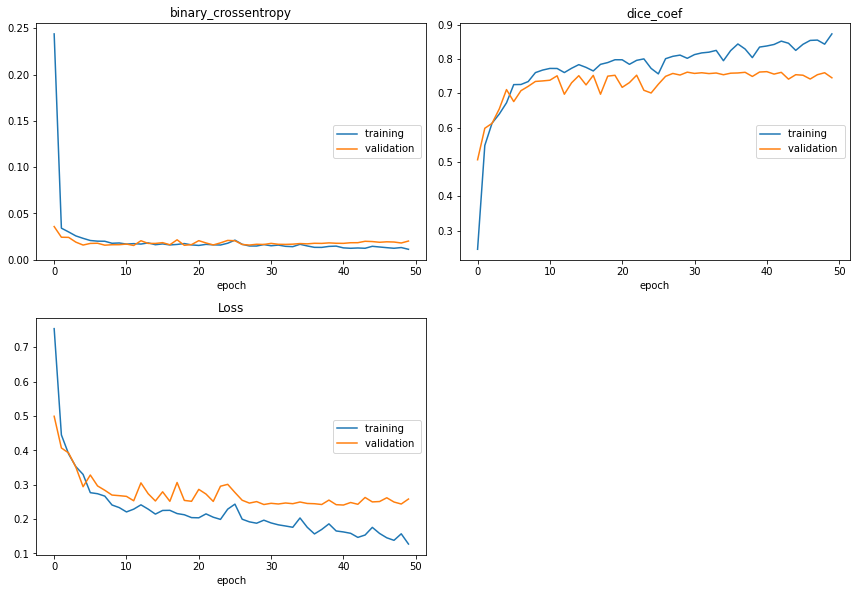

binary_crossentropy
	training         	 (min:    0.011, max:    0.351, cur:    0.011)
	validation       	 (min:    0.015, max:    0.057, cur:    0.020)
dice_coef
	training         	 (min:    0.170, max:    0.873, cur:    0.873)
	validation       	 (min:    0.448, max:    0.763, cur:    0.745)
Loss
	training         	 (min:    0.127, max:    0.830, cur:    0.127)
	validation       	 (min:    0.241, max:    0.557, cur:    0.259)
54/54 [==============================] - 277s 5s/step - loss: 0.1275 - binary_crossentropy: 0.0113 - dice_coef: 0.8728 - val_loss: 0.2585 - val_binary_crossentropy: 0.0202 - val_dice_coef: 0.7450
------------------------------
Training finished
------------------------------


In [57]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'
PROJECT_NAME = '3dDenseUnet_att_hyper_c1_dropout'
train(att_input= True, inter_channel = 1)

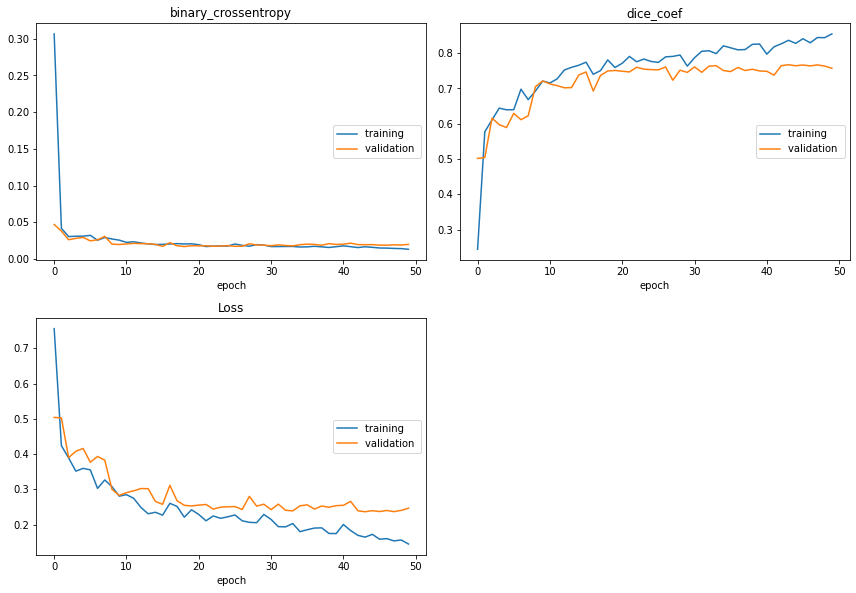

binary_crossentropy
	training         	 (min:    0.011, max:    0.351, cur:    0.013)
	validation       	 (min:    0.015, max:    0.057, cur:    0.020)
dice_coef
	training         	 (min:    0.170, max:    0.873, cur:    0.855)
	validation       	 (min:    0.448, max:    0.767, cur:    0.757)
Loss
	training         	 (min:    0.127, max:    0.830, cur:    0.145)
	validation       	 (min:    0.236, max:    0.557, cur:    0.246)
54/54 [==============================] - 276s 5s/step - loss: 0.1447 - binary_crossentropy: 0.0132 - dice_coef: 0.8548 - val_loss: 0.2464 - val_binary_crossentropy: 0.0199 - val_dice_coef: 0.7573
------------------------------
Training finished
------------------------------


In [58]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = '3dDenseUnet_dropout'
train(att_input= False)

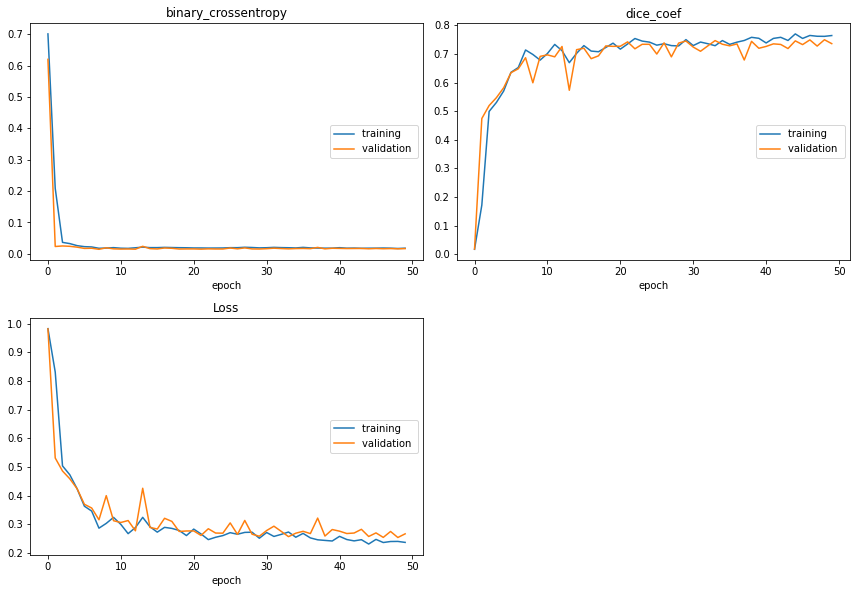

binary_crossentropy
	training         	 (min:    0.017, max:    0.701, cur:    0.018)
	validation       	 (min:    0.014, max:    0.620, cur:    0.017)
dice_coef
	training         	 (min:    0.017, max:    0.770, cur:    0.765)
	validation       	 (min:    0.000, max:    0.750, cur:    0.736)
Loss
	training         	 (min:    0.230, max:    0.983, cur:    0.236)
	validation       	 (min:    0.253, max:    1.000, cur:    0.266)
67/67 [==============================] - 348s 5s/step - loss: 0.2362 - binary_crossentropy: 0.0179 - dice_coef: 0.7645 - val_loss: 0.2661 - val_binary_crossentropy: 0.0166 - val_dice_coef: 0.7362
------------------------------
Training finished
------------------------------


In [48]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = '3dDenseUnet_dropout_augmentation'
train(att_input= False)

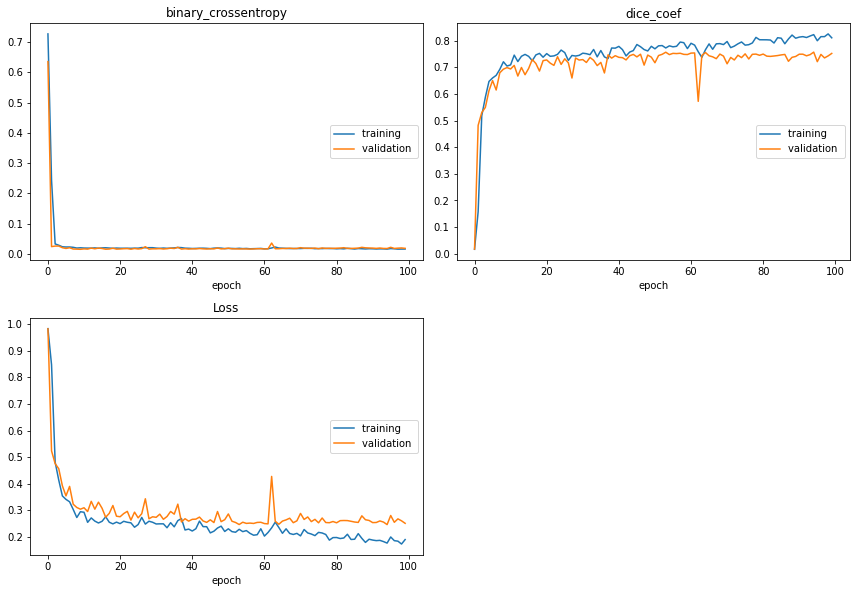

binary_crossentropy
	training         	 (min:    0.016, max:    0.727, cur:    0.016)
	validation       	 (min:    0.014, max:    0.635, cur:    0.018)
dice_coef
	training         	 (min:    0.017, max:    0.825, cur:    0.810)
	validation       	 (min:    0.000, max:    0.756, cur:    0.752)
Loss
	training         	 (min:    0.174, max:    0.983, cur:    0.190)
	validation       	 (min:    0.247, max:    1.000, cur:    0.252)
67/67 [==============================] - 343s 5s/step - loss: 0.1904 - binary_crossentropy: 0.0158 - dice_coef: 0.8101 - val_loss: 0.2515 - val_binary_crossentropy: 0.0181 - val_dice_coef: 0.7516
------------------------------
Training finished
------------------------------


In [50]:
EPOCHS = 100
os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = '3dDenseUnet_dropout_augmentation'
train(att_input= False)

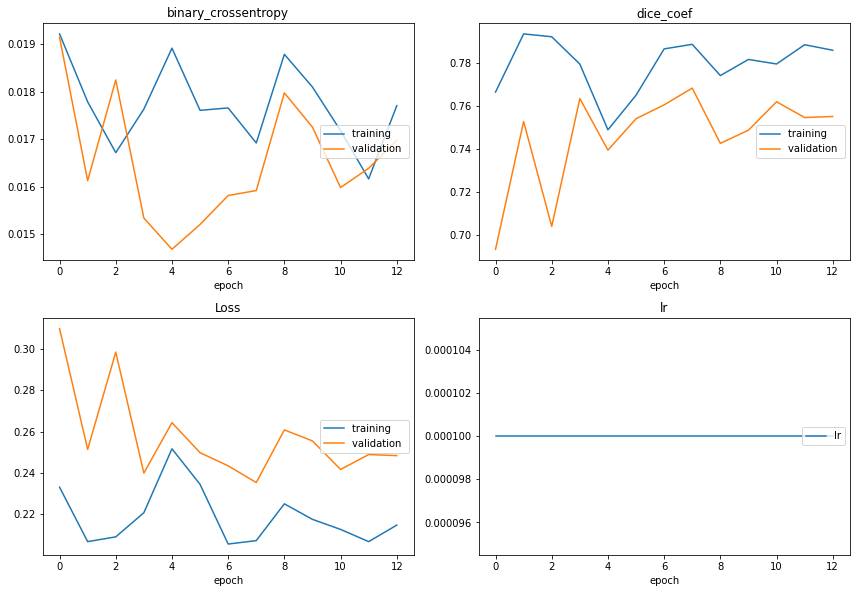

binary_crossentropy
	training         	 (min:    0.012, max:    0.644, cur:    0.018)
	validation       	 (min:    0.014, max:    0.644, cur:    0.017)
dice_coef
	training         	 (min:    0.000, max:    0.873, cur:    0.786)
	validation       	 (min:    0.000, max:    0.772, cur:    0.755)
Loss
	training         	 (min:    0.127, max:    1.000, cur:    0.215)
	validation       	 (min:    0.232, max:    1.000, cur:    0.248)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
67/67 [==============================] - 364s 5s/step - loss: 0.2148 - binary_crossentropy: 0.0177 - dice_coef: 0.7858 - val_loss: 0.2484 - val_binary_crossentropy: 0.0170 - val_dice_coef: 0.7551 - lr: 1.0000e-04
Epoch 14/100
40/67 [================>.............] - ETA: 2:01 - loss: 0.2244 - binary_crossentropy: 0.0178 - dice_coef: 0.7756

KeyboardInterrupt: 

In [34]:

EPOCHS = 100

os.environ["CUDA_VISIBLE_DEVICES"]='1'
PROJECT_NAME = '3dDenseUnet_dropout_elastic_augmentation.h5'
train(att_input= False, inter_channel = 1, loss_function= dice_coef_loss, retrain = PROJECT_NAME)

In [ ]:

EPOCHS = 50
os.environ["CUDA_VISIBLE_DEVICES"]='1'
PROJECT_NAME = '3dDenseUnet_dropout_elas_aug_window'
train(att_input= False, loss_function= dice_coef_loss,retrain = PROJECT_NAME)

3dDenseUnet_dropout_elas_aug_window
------------------------------
Creating and compiling model...
------------------------------
Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 144, 144, 14 0                                            
__________________________________________________________________________________________________
conv3d_946 (Conv3D)             (None, 144, 144, 144 1760        input_49[0][0]                   
__________________________________________________________________________________________________
concatenate_1081 (Concatenate)  (None, 144, 144, 144 0           input_49[0][0]                   
                                                                 conv3d_946[0][0]                 
____________________________________________________________

------------------------------
Fitting model...
------------------------------
steps_per_epoch =  70
validation_steps =  14
Epoch 1/50
19/70 [=======>......................] - ETA: 3:11 - loss: 0.1728 - binary_crossentropy: 0.0152 - dice_coef: 0.8272